In [1]:
import os, gc, logging, warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import cudf

import tensorflow as tf
warnings.filterwarnings("ignore")

# Load Data

In [2]:
train = cudf.read_csv('../input/tabular-playground-series-feb-2022/train.csv').set_index("row_id")
test = cudf.read_csv('../input/tabular-playground-series-feb-2022/test.csv').set_index("row_id")

sample_submission = pd.read_csv("../input/tabular-playground-series-feb-2022/sample_submission.csv")

train = train.to_pandas()
test = test.to_pandas()

feature_cols = test.columns.tolist()

le = LabelEncoder()
train["target"] = le.fit_transform(train["target"])

for col in feature_cols:
    train[col] = train[col].astype("float32")
    test[col] = test[col].astype("float32")

# AutoEncoder for Dimensionality Reduction

**AutoEncoder** is an **unsupervised Artificial Neural Network** that attempts to encode the data by compressing it into the lower dimensions (bottleneck layer or code) and then decoding the data to reconstruct the original input. The bottleneck layer (or code) holds the compressed representation of the input data [[1](https://www.analyticsvidhya.com/blog/2021/06/dimensionality-reduction-using-autoencoders-in-python/#:~:text=AutoEncoder%20is%20an%20unsupervised%20Artificial,to%20reconstruct%20the%20original%20input.&text=AutoEncoders%20usually%20consist%20of%20an%20encoder%20and%20a%20decoder.)]

![autoencoder](https://miro.medium.com/max/882/0*j9IZ2cJa2hS3TlOd.png)

[Image Source](https://medium.datadriveninvestor.com/dimensionality-reduction-using-an-autoencoder-in-python-bf540bb3f085)

In [3]:
n_components = 2

tf.random.set_seed(42)
KI = tf.keras.initializers.glorot_uniform(seed=42)

encoder_input = tf.keras.layers.Input(shape=(train[feature_cols].shape[1],))
encoder_x = tf.keras.layers.Dense(256, activation="relu", kernel_initializer=KI)(encoder_input)
encoder_x = tf.keras.layers.Dense(128, activation="relu", kernel_initializer=KI)(encoder_input)
encoder_output = tf.keras.layers.Dense(n_components, activation="swish", kernel_initializer=KI)(encoder_x)

decoder_input = tf.keras.layers.Dense(128, activation="relu", kernel_initializer=KI)(encoder_output)
decoder_x = tf.keras.layers.Dense(256, activation="relu", kernel_initializer=KI)(decoder_input)
decoder_output = tf.keras.layers.Dense(train[feature_cols].shape[1], kernel_initializer=KI)(decoder_x)

encoder = tf.keras.Model(encoder_input, encoder_output)
autoencoder = tf.keras.Model(encoder_input, decoder_output)

autoencoder.compile(optimizer="adam", loss="mse")

history = autoencoder.fit(train[feature_cols], train[feature_cols], epochs=5)

Epoch 1/5
6250/6250 [==============================] - 12s 2ms/step - loss: 7.5810e-06
Epoch 2/5
6250/6250 [==============================] - 11s 2ms/step - loss: 6.8647e-06
Epoch 3/5
6250/6250 [==============================] - 11s 2ms/step - loss: 6.7616e-06
Epoch 4/5
6250/6250 [==============================] - 11s 2ms/step - loss: 6.6850e-06
Epoch 5/5
6250/6250 [==============================] - 11s 2ms/step - loss: 6.6390e-06


In [4]:
enc_x = encoder.predict(train[feature_cols])
enc_t = encoder.predict(test[feature_cols])

enc_cols = []
for i in range(n_components):
    col = f"ENC{i+1}"
    train[col] = enc_x[:,i]
    train[col] = enc_x[:,i]
    test[col] = enc_t[:,i]
    test[col] = enc_t[:,i]
    enc_cols.append(col)

del autoencoder, encoder, history, enc_x, enc_t
gc.collect()

train[enc_cols].head()

ENC1      ENC2
row_id                    
0      -0.082761  0.062282
1       0.054712  0.044019
2       0.090612  0.066777
3       0.089539  0.079668
4      -0.061427 -0.040064

How our encoded data looks like

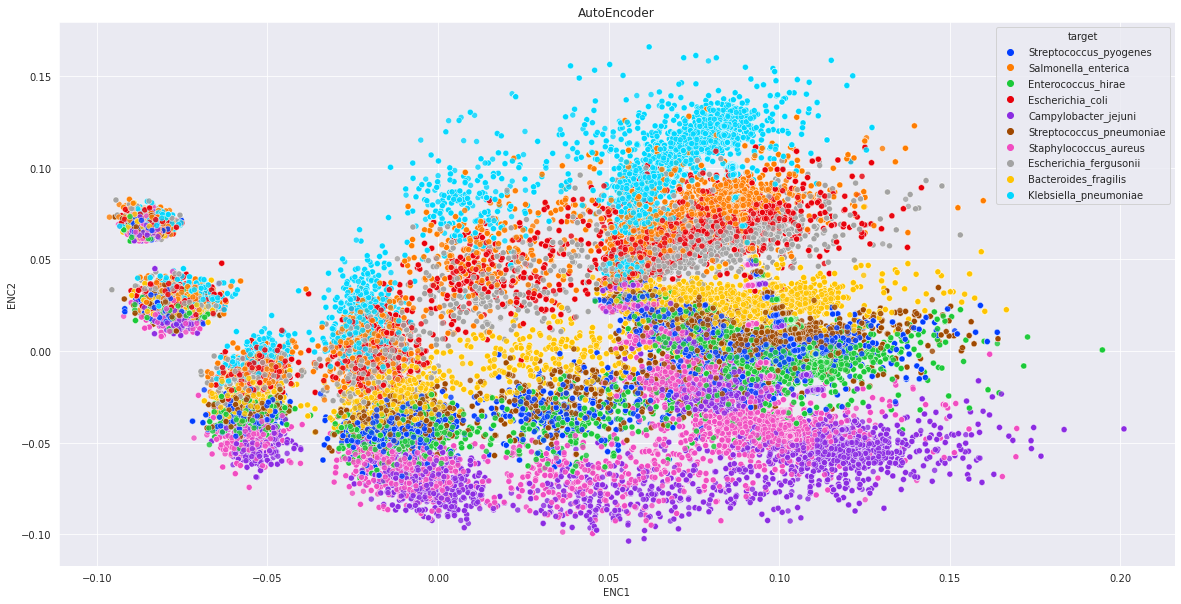

In [5]:
df = train[["ENC1", "ENC2", "target"]].copy()
df["target"] = le.inverse_transform(df["target"])
plt.figure(figsize=(20,10))
sns.scatterplot(data=df, x="ENC1", y="ENC2", hue="target", alpha=0.8, palette="bright")
plt.title("AutoEncoder")
plt.show()

Let's see each bacteria species separately.

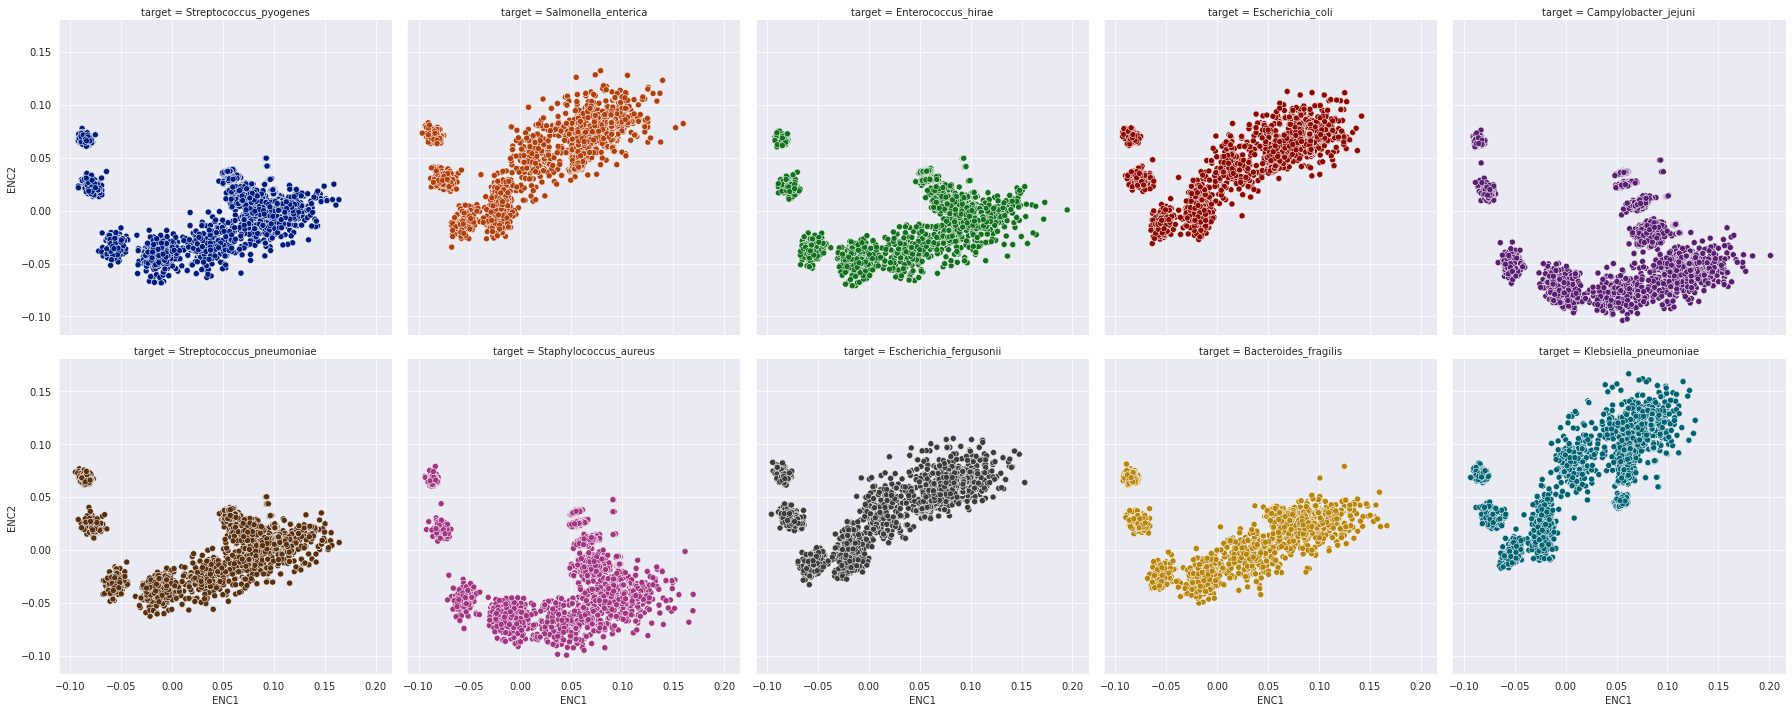

In [6]:
sns.relplot(data=df, 
            x="ENC1",
            y="ENC2",
            col="target", 
            hue="target",
            kind="scatter", 
            palette=sns.color_palette("dark"), 
            col_wrap=5,
            legend=False)
plt.show()

**As you can see from two above plots, different bacteria species are stacked on each other and they are good separable, but there are two clusters at the left side, which there are from all targets there.** Probably those are the samples which has been made by noise. 

# PCA | LDA | SVD

In [7]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(train[feature_cols])
T_pca = pca.transform(test[feature_cols])

pca_cols = [f"PC{i+1}" for i in range(X_pca.shape[1])]

X_pca = pd.DataFrame(X_pca, columns=pca_cols, index=train.index)
T_pca = pd.DataFrame(T_pca, columns=pca_cols, index=test.index)

train = pd.concat([train, X_pca], axis=1)
test = pd.concat([test, T_pca], axis=1)

del pca, X_pca, T_pca

train[pca_cols].head()

PC1       PC2
row_id                    
0       0.006646  0.069854
1      -0.025797  0.006773
2      -0.029070 -0.005515
3      -0.032686 -0.006226
4       0.042883  0.053586

In [8]:
lda = LinearDiscriminantAnalysis(n_components=2, solver='svd')
X_lda = lda.fit_transform(train[feature_cols], train["target"])
T_lda = lda.transform(test[feature_cols])

lda_cols = [f"LDA{i+1}" for i in range(X_lda.shape[1])]

X_lda = pd.DataFrame(X_lda, columns=lda_cols, index=train.index)
T_lda = pd.DataFrame(T_lda, columns=lda_cols, index=test.index)

train = pd.concat([train, X_lda], axis=1)
test = pd.concat([test, T_lda], axis=1)

del lda, X_lda, T_lda
gc.collect()

train[lda_cols].head()

LDA1      LDA2
row_id                    
0      -0.223297 -0.255829
1       1.095291  0.089944
2       1.620144 -0.380593
3       2.744332 -0.007739
4      -1.364849  0.026336

In [9]:
svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42)

X_svd = svd.fit_transform(train[feature_cols])
T_svd = svd.transform(test[feature_cols])

svd_cols = [f"SVD{i+1}" for i in range(X_svd.shape[1])]

X_svd = pd.DataFrame(X_svd, columns=svd_cols, index=train.index)
T_svd = pd.DataFrame(T_svd, columns=svd_cols, index=test.index)

train = pd.concat([train, X_svd], axis=1)
test = pd.concat([test, T_svd], axis=1)

del svd, X_svd, T_svd, 
gc.collect()

train[svd_cols].head()

SVD1      SVD2
row_id                    
0       0.043058  0.069887
1       0.004064  0.012067
2      -0.001524  0.000231
3      -0.003282  0.000432
4       0.075476  0.048681

# Compare Results

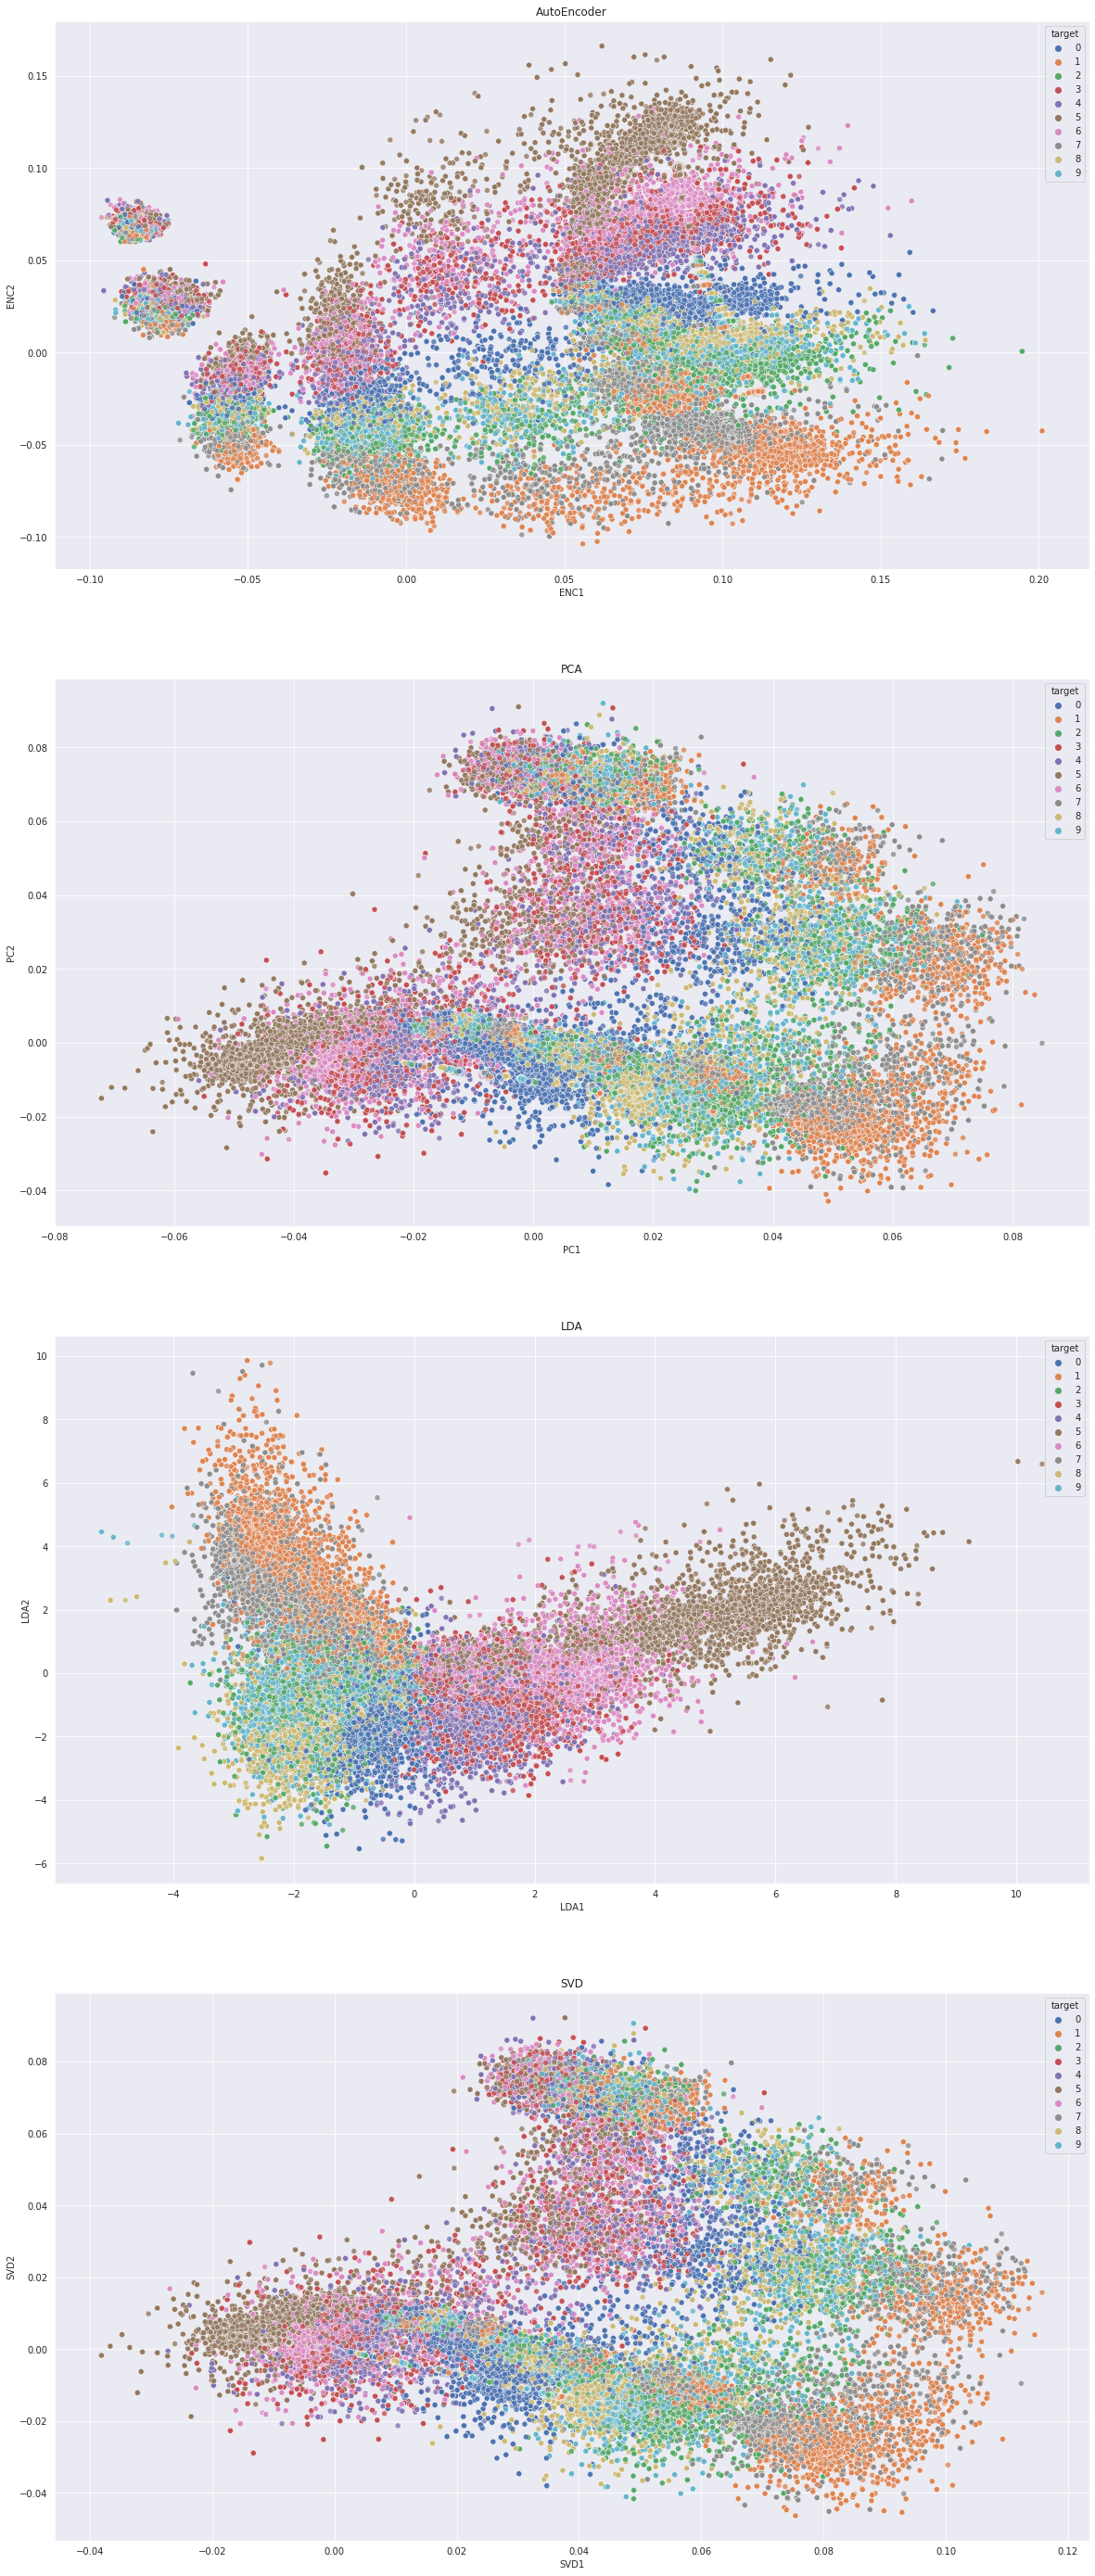

In [10]:
plt.figure(figsize=(20,50))
plt.subplot(4,1,1)
sns.scatterplot(data=train, x="ENC1", y="ENC2", hue="target", alpha=0.8, palette="deep")
plt.title("AutoEncoder")

plt.subplot(4,1,2)
sns.scatterplot(data=train, x="PC1", y="PC2", hue="target", alpha=0.8, palette="deep")
plt.title("PCA")

plt.subplot(4,1,3)
sns.scatterplot(data=train, x="LDA1", y="LDA2", hue="target", alpha=0.8, palette="deep")
plt.title("LDA")

plt.subplot(4,1,4)
sns.scatterplot(data=train, x="SVD1", y="SVD2", hue="target", alpha=0.8, palette="deep")
plt.title("SVD")

plt.show()

In [11]:
feature_cols += enc_cols
feature_cols += pca_cols
feature_cols += svd_cols

# Train Neural Network

In [12]:
gc.collect()

x_train, x_valid, y_train, y_valid = train_test_split(train[feature_cols], train["target"], test_size=0.2, random_state=42, stratify=train["target"])   

KI = tf.keras.initializers.glorot_uniform(seed=2022)

input_nn = tf.keras.layers.Input(shape=(train[feature_cols].shape[1],))
x = tf.keras.layers.Dense(128, activation="relu", kernel_initializer=KI)(input_nn)
x = tf.keras.layers.Dense(256, activation="relu", kernel_initializer=KI)(x)
x = tf.keras.layers.Dense(512, activation="relu", kernel_initializer=KI)(x)
x = tf.keras.layers.Dense(256, activation="relu", kernel_initializer=KI)(x)
x = tf.keras.layers.Dense(128, activation="relu", kernel_initializer=KI)(x)
output_nn = tf.keras.layers.Dense(10, activation="softmax", kernel_initializer=KI)(x)

model = tf.keras.Model(input_nn, output_nn)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 292)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               37504     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_8 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1290

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(5e-3), 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])

cb_es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, mode="min", restore_best_weights=True, verbose=1)
cb_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, mode="min", min_lr=1e-5, verbose=1)

history = model.fit(x_train, 
                    y_train, 
                    validation_data=(x_valid, y_valid), 
                    epochs=50, 
                    callbacks=[cb_lr, cb_es])

Epoch 1/50
5000/5000 [==============================] - 12s 2ms/step - loss: 0.5934 - accuracy: 0.7663 - val_loss: 0.3680 - val_accuracy: 0.8541
Epoch 2/50
5000/5000 [==============================] - 12s 2ms/step - loss: 0.3441 - accuracy: 0.8641 - val_loss: 0.3291 - val_accuracy: 0.8723
Epoch 3/50
5000/5000 [==============================] - 12s 2ms/step - loss: 0.2839 - accuracy: 0.8880 - val_loss: 0.3222 - val_accuracy: 0.8842
Epoch 4/50
5000/5000 [==============================] - 12s 2ms/step - loss: 0.2491 - accuracy: 0.9030 - val_loss: 0.2434 - val_accuracy: 0.9069
Epoch 5/50
5000/5000 [==============================] - 13s 3ms/step - loss: 0.2303 - accuracy: 0.9118 - val_loss: 0.1972 - val_accuracy: 0.9198
Epoch 6/50
5000/5000 [==============================] - 12s 2ms/step - loss: 0.2132 - accuracy: 0.9181 - val_loss: 0.2002 - val_accuracy: 0.9202
Epoch 7/50
5000/5000 [==============================] - 13s 3ms/step - loss: 0.2004 - accuracy: 0.9232 - val_loss: 0.1824 - val_ac

# Submission

In [14]:
preds_test = np.argmax(model.predict(test[feature_cols]),axis=1)
preds_test = le.inverse_transform(preds_test)

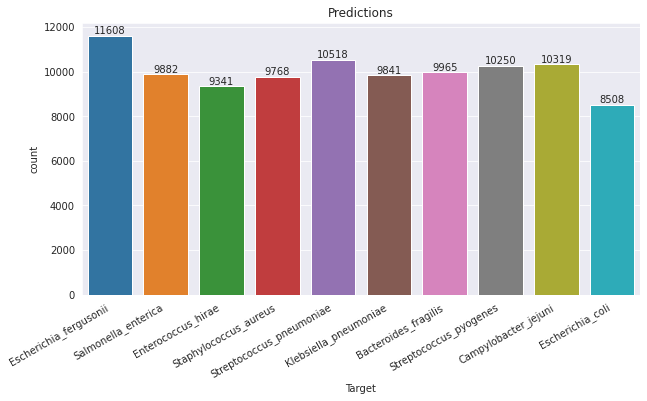

In [15]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x=preds_test)
plt.title("Predictions")
plt.xlabel("Target")
plt.xticks(rotation=30, ha='right')
ax.bar_label(ax.containers[0])
plt.show()

In [16]:
sample_submission['target'] = preds_test
sample_submission.to_csv("submission.csv", index=False)
sample_submission.head()

row_id                  target
0  200000  Escherichia_fergusonii
1  200001     Salmonella_enterica
2  200002      Enterococcus_hirae
3  200003     Salmonella_enterica
4  200004   Staphylococcus_aureus